## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.9 or later is installed (ideally I would generatlly recommend Python 3.10), as well as Scikit-Learn ≥ 1.0

In [1]:
# Python ≥3.9 is required
import sys
assert sys.version_info >= (3, 9)

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Precision options
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.3f}'.format

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 1. Get the Data

First of all let's import the data from the CSV file.

In [79]:
train_data = pd.read_csv(r'C:\Users\nuhaa\OneDrive\Desktop\train.csv')
test_data = pd.read_csv(r'C:\Users\nuhaa\OneDrive\Desktop\test.csv')
original_data = pd.read_csv(r'C:\Users\nuhaa\OneDrive\Desktop\credit_risk_dataset.csv')
sample_submission = pd.read_csv(r'C:\Users\nuhaa\OneDrive\Desktop\sample_submission.csv')

* train.csv - the training dataset; loan_status is the binary target
* test.csv - the test dataset; your objective is to predict probability of the target loan_status for each row
* sample_submission.csv - a sample submission file in the correct format

In [ ]:
train_data.shape, test_data.shape, original_data.shape, sample_submission.shape

((58645, 13), (39098, 12), (32581, 12), (39098, 2))

In [127]:
sample_submission.head()

,id,loan_status
0,58645,0.500
1,58646,0.500
2,58647,0.500
3,58648,0.500
4,58649,0.500


In [ ]:
# Check if indices match for x_test and y_test
print((sample_submission.index == test_data.index).all())

True


In [ ]:
train_data.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [5]:
original_data.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [6]:
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.000,EDUCATION,B,6000,11.490,0.170,N,14,0
1,1,22,56000,OWN,6.000,MEDICAL,C,4000,13.350,0.070,N,2,0
2,2,29,28800,OWN,8.000,PERSONAL,A,6000,8.900,0.210,N,10,0
3,3,30,70000,RENT,14.000,VENTURE,B,12000,11.110,0.170,N,5,0
4,4,22,60000,RENT,2.000,MEDICAL,A,6000,6.920,0.100,N,3,0


In [7]:
original_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.000,PERSONAL,D,35000,16.020,1,0.590,Y,3
1,21,9600,OWN,5.000,EDUCATION,B,1000,11.140,0,0.100,N,2
2,25,9600,MORTGAGE,1.000,MEDICAL,C,5500,12.870,1,0.570,N,3
3,23,65500,RENT,4.000,MEDICAL,C,35000,15.230,1,0.530,N,2
4,24,54400,RENT,8.000,MEDICAL,C,35000,14.270,1,0.550,Y,4


In [8]:
train_data.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000,58645.000,58645.000,58645.000,58645.000,58645.000,58645.000,58645.000,58645.000
mean,29322.000,27.551,64046.173,4.701,9217.557,10.678,0.159,5.814,0.142
std,16929.498,6.033,37931.107,3.960,5563.807,3.035,0.092,4.029,0.349
min,0.000,20.000,4200.000,0.000,500.000,5.420,0.000,2.000,0.000
25%,14661.000,23.000,42000.000,2.000,5000.000,7.880,0.090,3.000,0.000
50%,29322.000,26.000,58000.000,4.000,8000.000,10.750,0.140,4.000,0.000
75%,43983.000,30.000,75600.000,7.000,12000.000,12.990,0.210,8.000,0.000
max,58644.000,123.000,1900000.000,123.000,35000.000,23.220,0.830,30.000,1.000


In [9]:
original_data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000,32581.000,31686.000,32581.000,29465.000,32581.000,32581.000,32581.000
mean,27.735,66074.848,4.790,9589.371,11.012,0.218,0.170,5.804
std,6.348,61983.119,4.143,6322.087,3.240,0.413,0.107,4.055
min,20.000,4000.000,0.000,500.000,5.420,0.000,0.000,2.000
25%,23.000,38500.000,2.000,5000.000,7.900,0.000,0.090,3.000
50%,26.000,55000.000,4.000,8000.000,10.990,0.000,0.150,4.000
75%,30.000,79200.000,7.000,12200.000,13.470,0.000,0.230,8.000
max,144.000,6000000.000,123.000,35000.000,23.220,1.000,0.830,30.000


In [10]:
sample_submission.head()

,id,loan_status
0,58645,0.500
1,58646,0.500
2,58647,0.500
3,58648,0.500
4,58649,0.500


In [80]:
train_data = train_data.drop(columns=['id'])

In [75]:
test_data = test_data.drop(columns=['id'])

In [81]:
df_train = pd.concat([train_data, original_data], axis=0)
df_train.shape

(91226, 12)

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91226 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


In [78]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,income_percentile,income_to_credit_history,estimated_annual_income,median_income_emp_group
0,37,35000,3.000,0.000,EDUCATION,1.000,6000,11.490,0.170,0.000,14,0,0.160,2500.000,35000.000,50000.000
1,22,56000,2.000,6.000,MEDICAL,2.000,4000,13.350,0.070,0.000,2,0,0.493,28000.000,47457.627,57269.500
2,29,28800,2.000,8.000,PERSONAL,0.000,6000,8.900,0.210,0.000,10,0,0.069,2880.000,23225.806,63996.000
3,30,70000,3.000,14.000,VENTURE,1.000,12000,11.110,0.170,0.000,5,0,0.674,14000.000,49295.775,73500.000
4,22,60000,3.000,2.000,MEDICAL,0.000,6000,6.920,0.100,0.000,3,0,0.551,20000.000,56603.774,50000.000


In [15]:
df_train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91226.000,91226.000,90331.000,91226.000,88110.000,91226.000,91226.000,91226.000
mean,27.616,64770.706,4.732,9350.349,10.790,0.163,5.810,0.169
std,6.148,47936.961,4.025,5848.605,3.109,0.097,4.038,0.375
min,20.000,4000.000,0.000,500.000,5.420,0.000,2.000,0.000
25%,23.000,40000.000,2.000,5000.000,7.880,0.090,3.000,0.000
50%,26.000,57000.000,4.000,8000.000,10.950,0.140,4.000,0.000
75%,30.000,78000.000,7.000,12000.000,13.110,0.220,8.000,0.000
max,144.000,6000000.000,123.000,35000.000,23.220,0.830,30.000,1.000


##### Description of the features:

Here follows a detailed description of all the features (i.e. columns/variables) in the dataset.


1. **`person_age`**: The age of the individual applying for the loan.
2. **`person_income`**: The annual income of the individual.
3. **`person_home_ownership`**: Type of home ownership, typically including categories like "Rent" or "Own."
4. **`person_emp_length`**: The number of years the person has been employed.
5. **`loan_intent`**: The purpose of the loan, with possible categories such as "Educational," "Medical," "Personal," "Venture," and others.
6. **`loan_grade`**: Loan grade assigned to the loan, typically ranging from A to D.
7. **`loan_amnt`**: The total amount requested for the loan.
8. **`loan_int_rate`**: The interest rate associated with the loan.
9. **`loan_percent_income`**: The proportion of the applicant's income that the loan payment represents.
10. **`cb_person_default_on_file`**: Indicates whether the individual has a history of default ("Yes" or "No").
11. **`cb_person_cred_hist_length`**: The length (in years) of the person’s credit history.
12. **`loan_status`**: The target variable for prediction, indicating loan approval or default status (often binary: 0 for no default, 1 for default).

These features include a mix of **numerical** (e.g., `person_age`, `person_income`) and **categorical** variables (e.g., `person_home_ownership`, `loan_intent`). Understanding each feature’s role will help in preprocessing, feature engineering, and model selection. Let me know if you’d like a deeper look into any specific feature or analysis suggestions!


## Business problem

We want to accurately predict to predict probability of the target loan_status (binary variable) for each row based on the information available in the dataset.

In [82]:
copy_train = df_train.copy()

In [16]:
df_train.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

## 2. Discover and Visualize the Data to Gain Insights

### 2.1 Outlier Detection

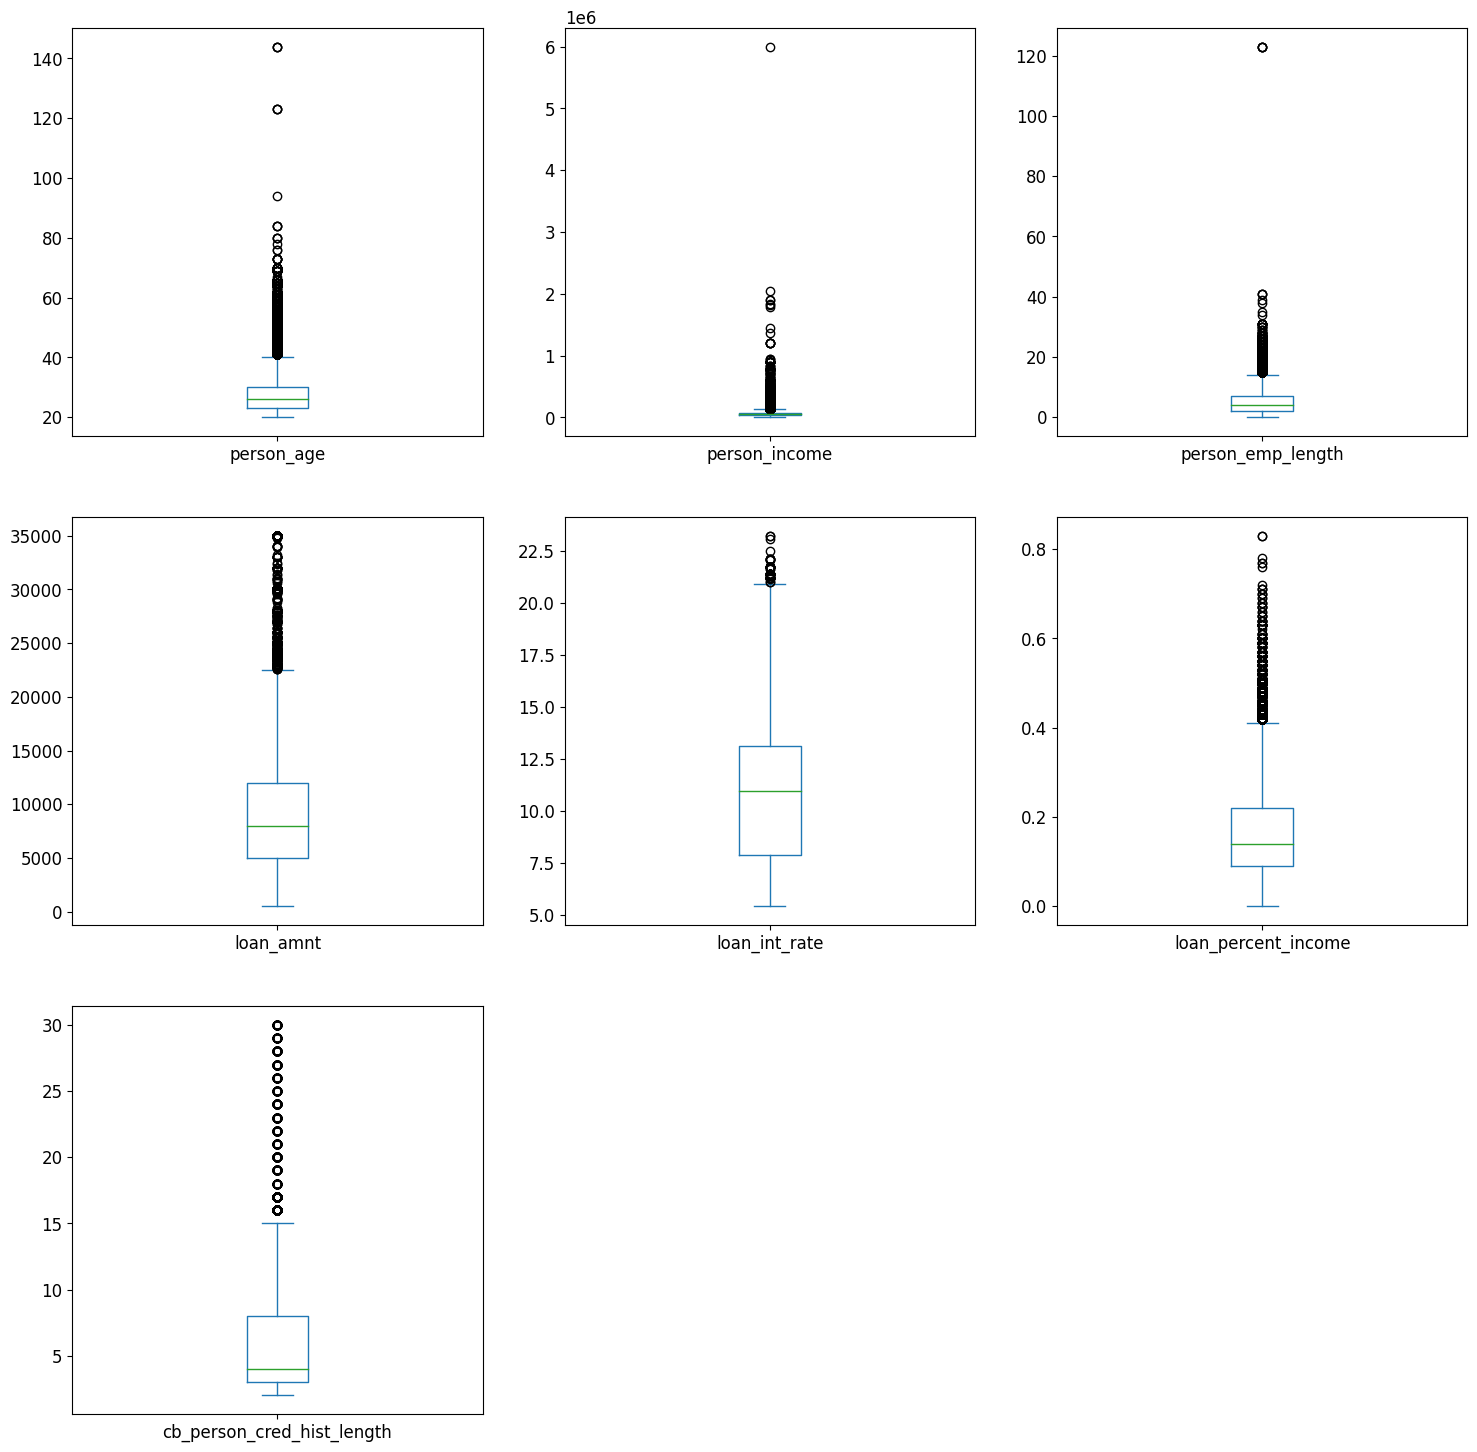

In [17]:
p = df_train[
    ['person_age', 'person_income','person_emp_length', 
     'loan_amnt','loan_int_rate', 
     'loan_percent_income','cb_person_cred_hist_length']
].plot.box(subplots=True, layout=(3, 3), figsize=(18,18))

### 2.2 Checking for duplicate rows and columns

In [18]:
# Identify duplicate columns
duplicate_columns = df_train.columns[df_train.columns.duplicated()].tolist()
print("Duplicate columns:", duplicate_columns)

Duplicate columns: []


In [19]:
# Check for duplicate rows in the dataset
duplicate_rows = df_train.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 165


In [20]:
# Remove duplicate rows
df_train = df_train.drop_duplicates()

In [21]:
# Drop duplicate columns
df_train = df_train.loc[:, ~df_train.columns.duplicated()]

In [22]:
# Check for duplicate index labels
print("Duplicate index labels:", df_train.index[df_train.index.duplicated()])

Duplicate index labels: Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            32571, 32572, 32573, 32574, 32575, 32576, 32577, 32578, 32579,
            32580],
           dtype='int64', length=32416)


In [23]:
# Reset index to remove duplicate labels
df_train = df_train.reset_index(drop=True)

### 2.3 Numerical features: looking for correlations

In [24]:
corr_matrix = df_train.corr(numeric_only=True)
corr_matrix

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
person_age,1.000,0.134,0.137,0.051,0.011,-0.035,0.868,-0.008
person_income,0.134,1.000,0.146,0.284,-0.029,-0.262,0.096,-0.152
person_emp_length,0.137,0.146,1.000,0.101,-0.085,-0.060,0.118,-0.092
loan_amnt,0.051,0.284,0.101,1.000,0.127,0.616,0.044,0.131
loan_int_rate,0.011,-0.029,-0.085,0.127,1.000,0.142,0.010,0.340
loan_percent_income,-0.035,-0.262,-0.060,0.616,0.142,1.000,-0.026,0.382
cb_person_cred_hist_length,0.868,0.096,0.118,0.044,0.010,-0.026,1.000,-0.008
loan_status,-0.008,-0.152,-0.092,0.131,0.340,0.382,-0.008,1.000


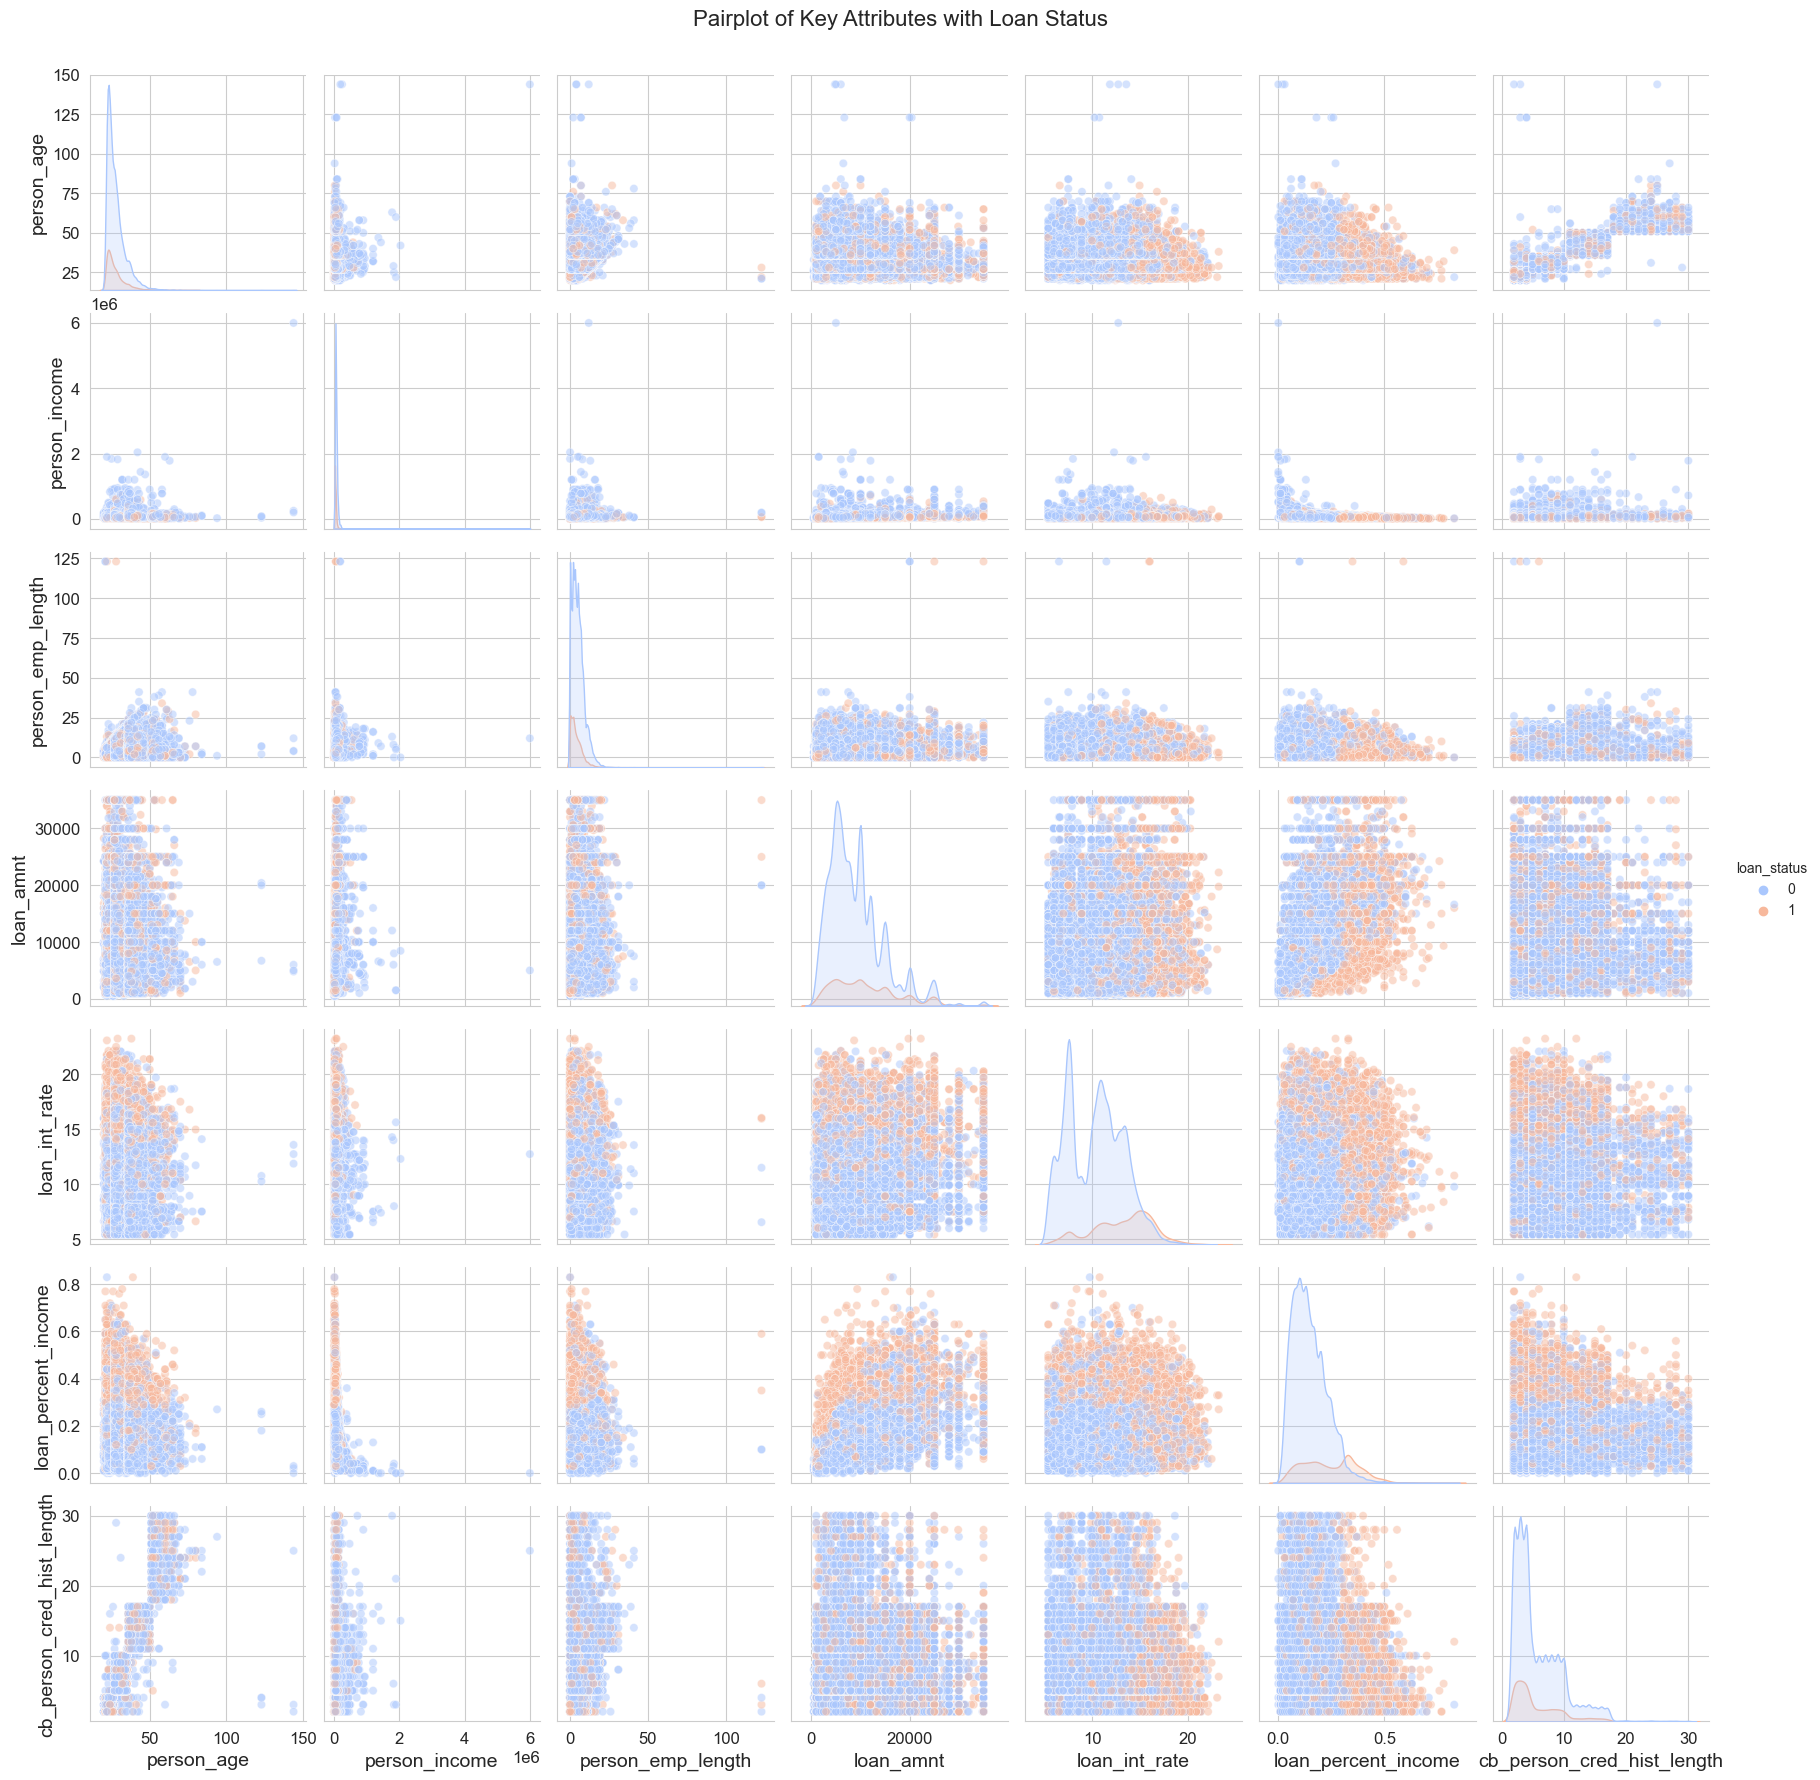

In [25]:
# Ensure seaborn and matplotlib styles for aesthetics
sns.set_style("whitegrid")

# Define attributes for plotting
attributes = [
    'person_age', 'person_income', 'person_emp_length', 
    'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
    'cb_person_cred_hist_length'
]

# Use seaborn pairplot with hue for target variable `loan_status`
sns.pairplot(
    df_train[attributes + ['loan_status']], 
    hue="loan_status",       # Color by `loan_status`
    palette="coolwarm",      # Choose a color palette
    plot_kws={'alpha': 0.5}  # Make points semi-transparent
)

plt.suptitle("Pairplot of Key Attributes with Loan Status", y=1.02, fontsize=16)
plt.show()


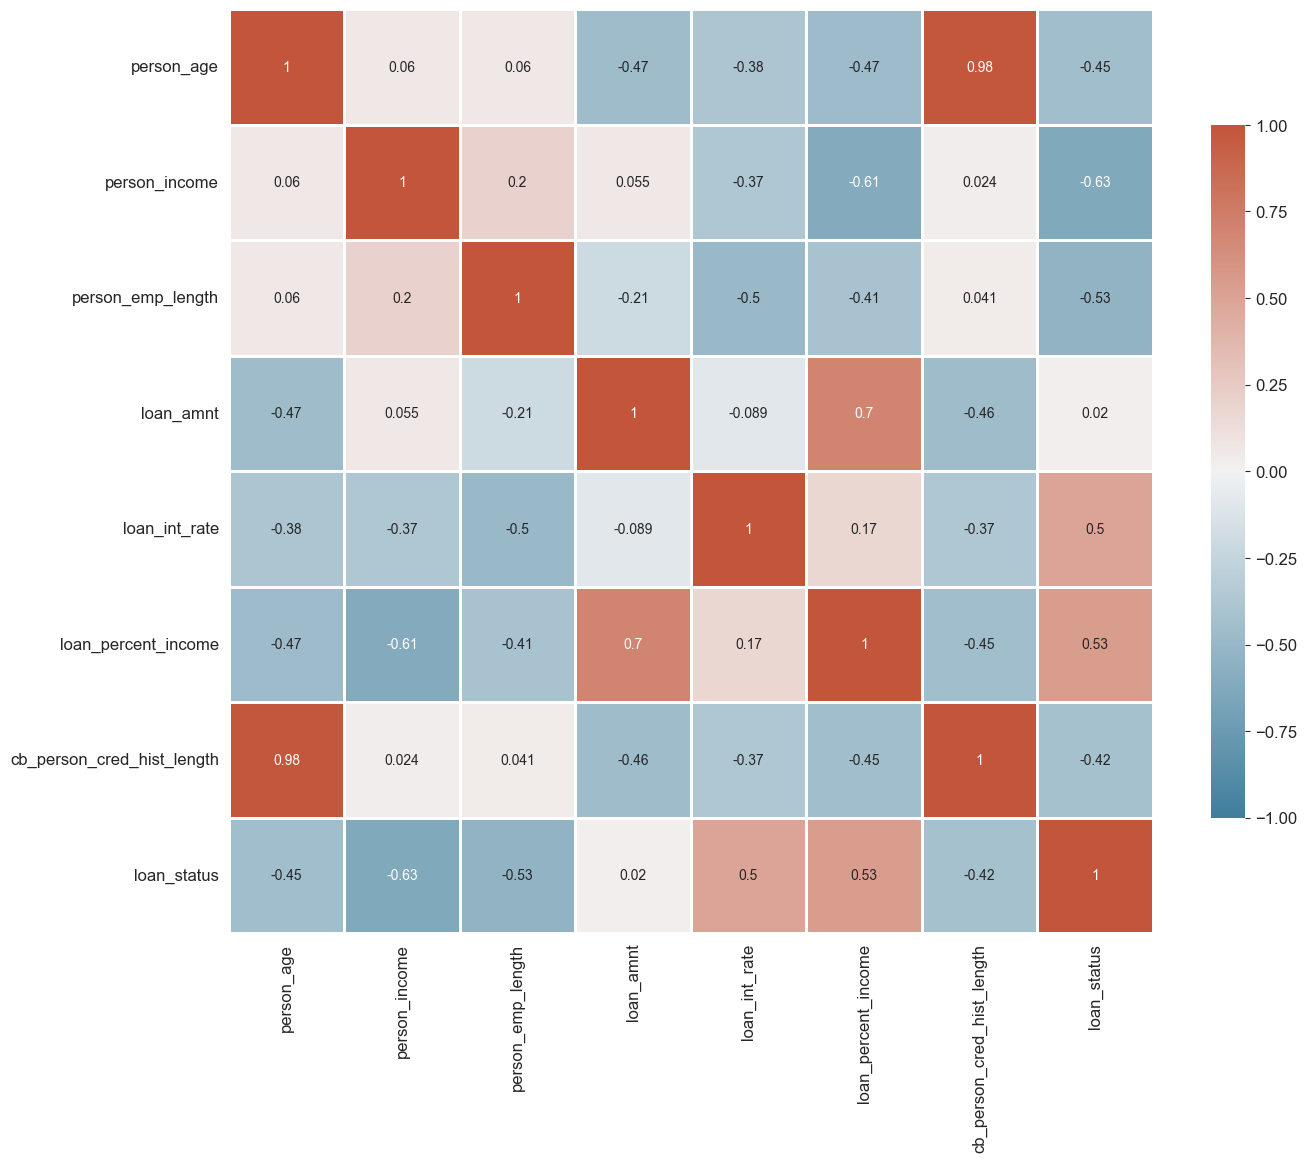

In [26]:
# check for multicolinearity with seaborn heatmap
# compute the correlation matrix
corr = round(corr_matrix.corr(numeric_only=True), 3)

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 12))

# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=1, cbar_kws={"shrink": .75}, annot=True)

plt.show()

We can now draw some conclusions. If we use 0.65 as a cutoff, we can clearly see that there is high correlation between `person_age` and `cb_person_credit_length` also between `loan_amnt` and `loan_percent_income`. Ideally we need to deal with multicolinearity in our features and retain those variabe that corelate more with predicted variable.

### 2.4 Visulize the data 

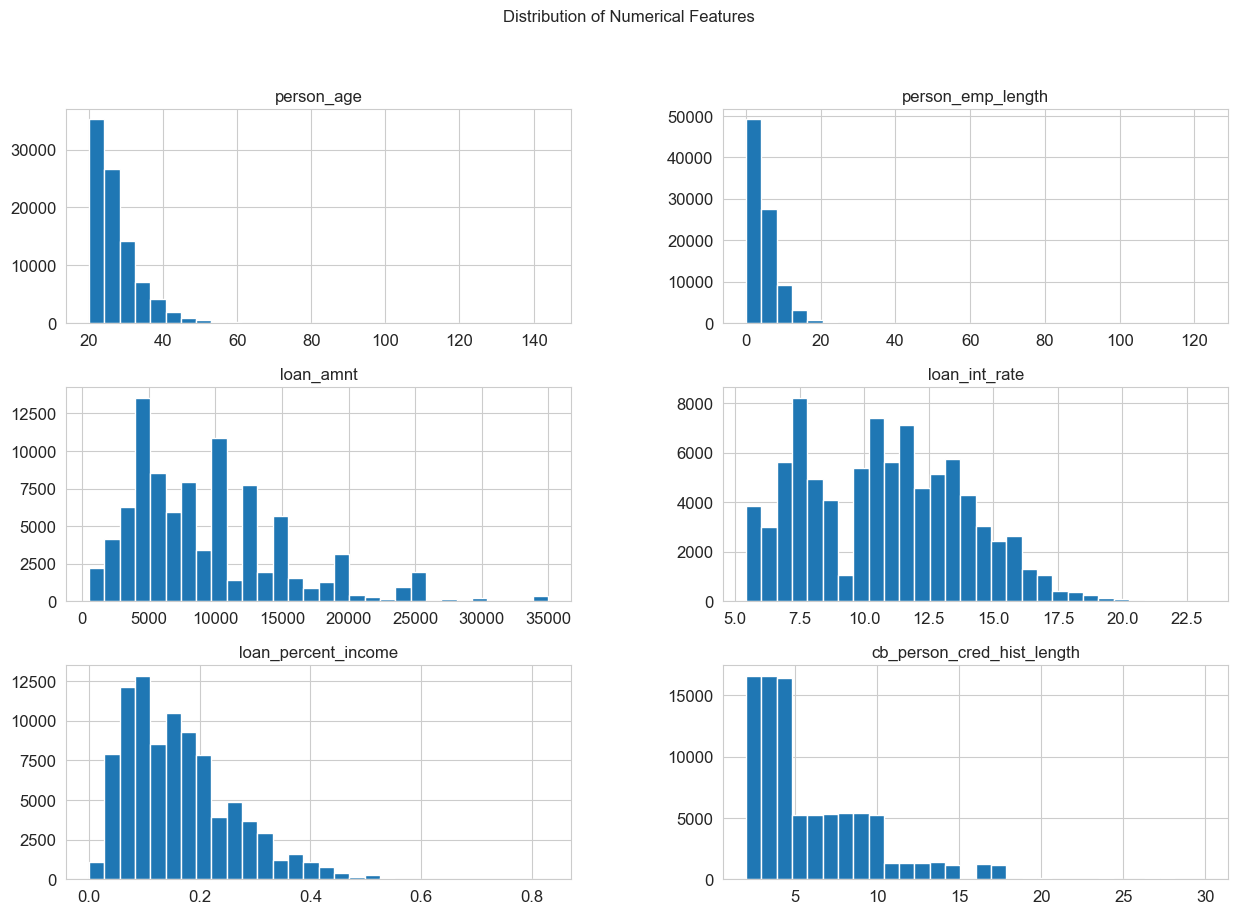

In [27]:
df_train[['person_age', 'person_emp_length', 'loan_amnt', 
          'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.show()

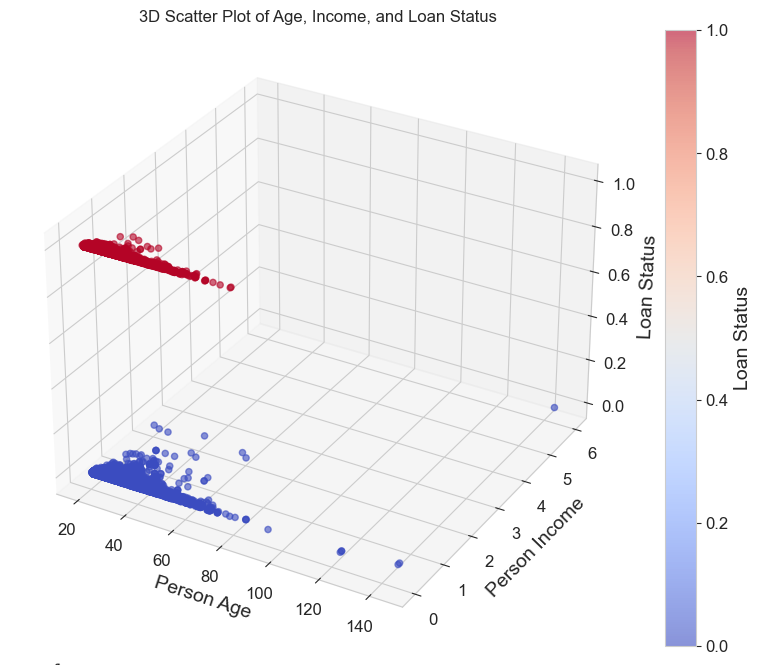

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_train['person_age'], df_train['person_income'], df_train['loan_status'],
                     c=df_train['loan_status'], cmap='coolwarm', alpha=0.6) # viridis
ax.set_xlabel("Person Age")
ax.set_ylabel("Person Income")
ax.set_zlabel("Loan Status")
plt.colorbar(scatter, label='Loan Status')
plt.title("3D Scatter Plot of Age, Income, and Loan Status")
plt.show()


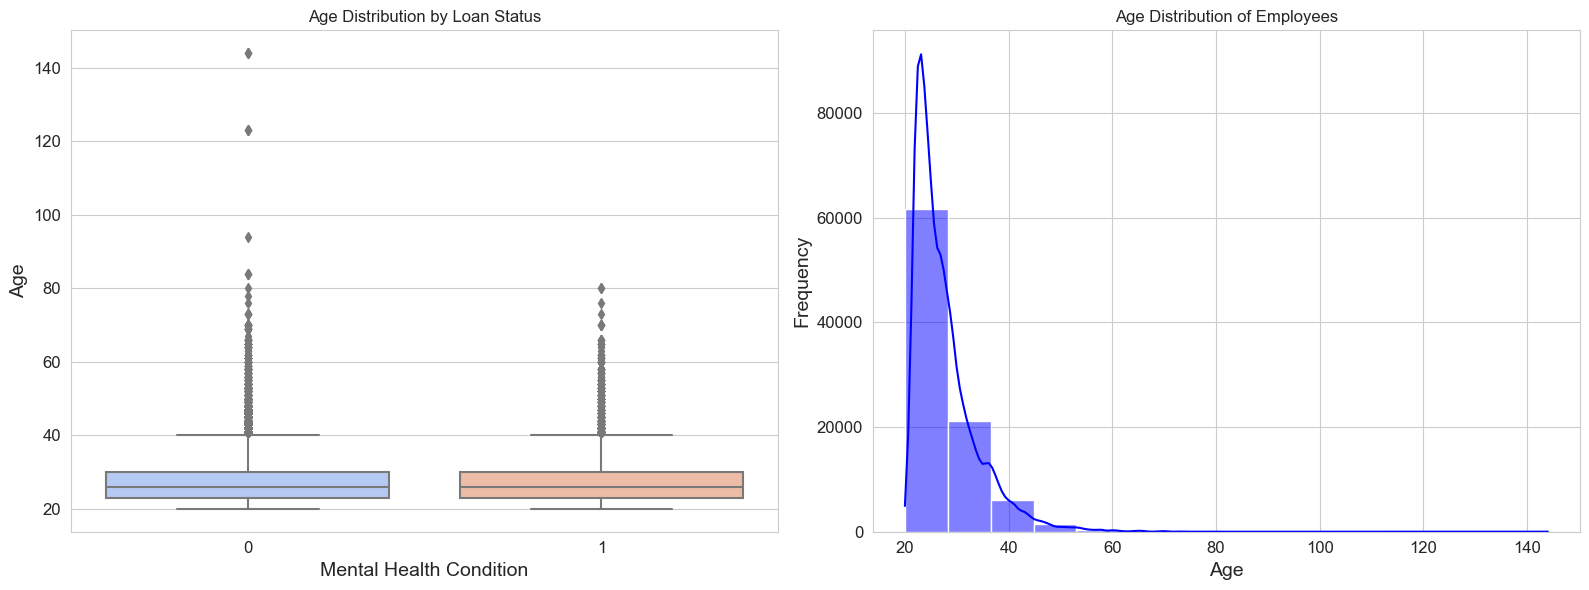

In [29]:
# Define age bins with a broader category for ages above 85
df_train['age_group'] = pd.cut(
    df_train['person_age'], 
    bins=[20, 30, 40, 50, 60, 70, 85, 130],  # Last bin captures ages from 85 to 123
    labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-85', '85+']
)


# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First Plot: Box Plot for Age Distribution by Mental Health Condition
sns.boxplot(x='loan_status', y='person_age', data=df_train, palette='coolwarm', ax=axes[0])
axes[0].set_title('Age Distribution by Loan Status')
axes[0].set_xlabel('Mental Health Condition')
axes[0].set_ylabel('Age')

# Second Plot: Histogram for Age Distribution
sns.histplot(df_train['person_age'], bins=15, kde=True, color='Blue', ax=axes[1])
axes[1].set_title('Age Distribution of Employees')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')

# Ensure plots are displayed without overlap
plt.tight_layout()

# Show the plots
plt.show()

# Drop the 'age_group' column
df_train = df_train.drop(['age_group'], axis=1)

In [30]:
# Set aesthetic style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("muted")

def plot_stacked_bar(df, x_col, hue_col, title, palette):
    # Create a cross-tabulation to count occurrences of each category
    crosstab = pd.crosstab(df[x_col], df[hue_col])

    # Plot the stacked bar chart
    ax = crosstab.plot(kind="bar", stacked=True, color=palette, figsize=(10, 6), edgecolor="black")
    
    # Add labels on top of each bar segment
    for bar in ax.containers:
        ax.bar_label(bar, label_type="center", fmt="%d", fontsize=9, color="white")

    # Customize plot appearance
    plt.xticks(rotation=45, ha="right")
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(x_col.replace('_', ' ').title(), fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.legend(title=hue_col.replace('_', ' ').title(), loc='upper right')
    plt.tight_layout()
    plt.show()

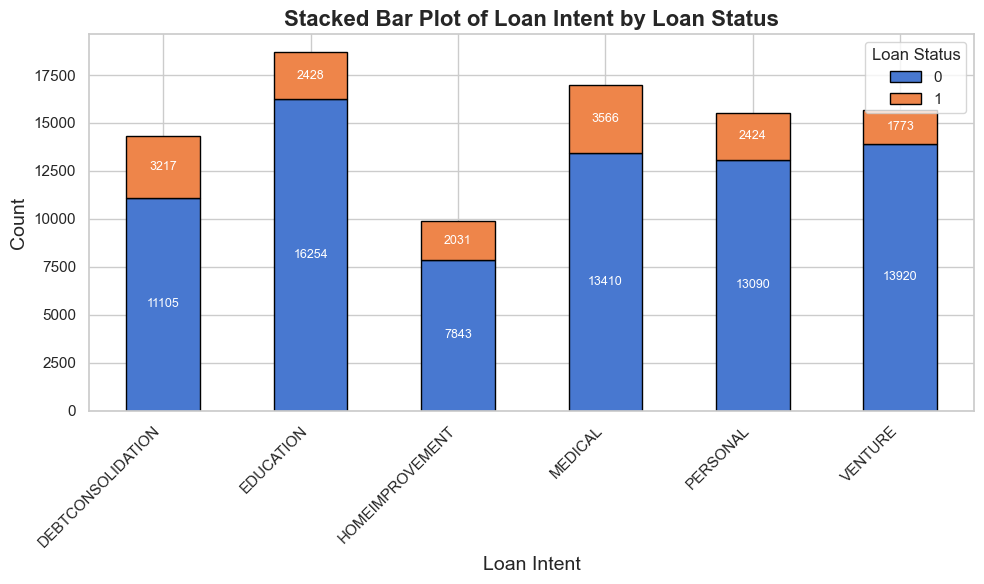

In [31]:

plot_stacked_bar(df_train, x_col='loan_intent', hue_col='loan_status', title="Stacked Bar Plot of Loan Intent by Loan Status", palette=palette)


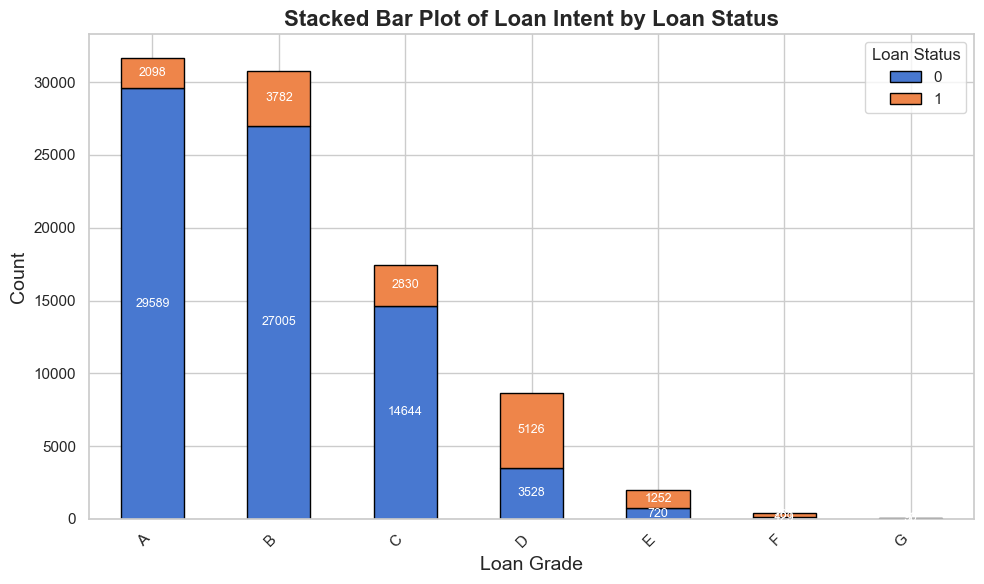

In [32]:

plot_stacked_bar(df_train, x_col='loan_grade', hue_col='loan_status', title="Stacked Bar Plot of Loan Intent by Loan Status", palette=palette)


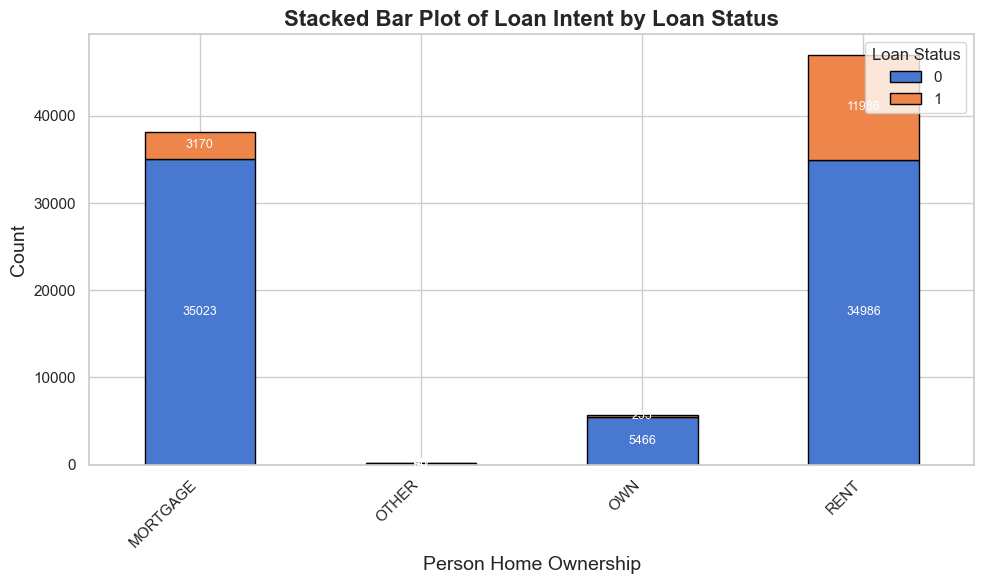

In [33]:

plot_stacked_bar(df_train, x_col='person_home_ownership', hue_col='loan_status', title="Stacked Bar Plot of Loan Intent by Loan Status", palette=palette)


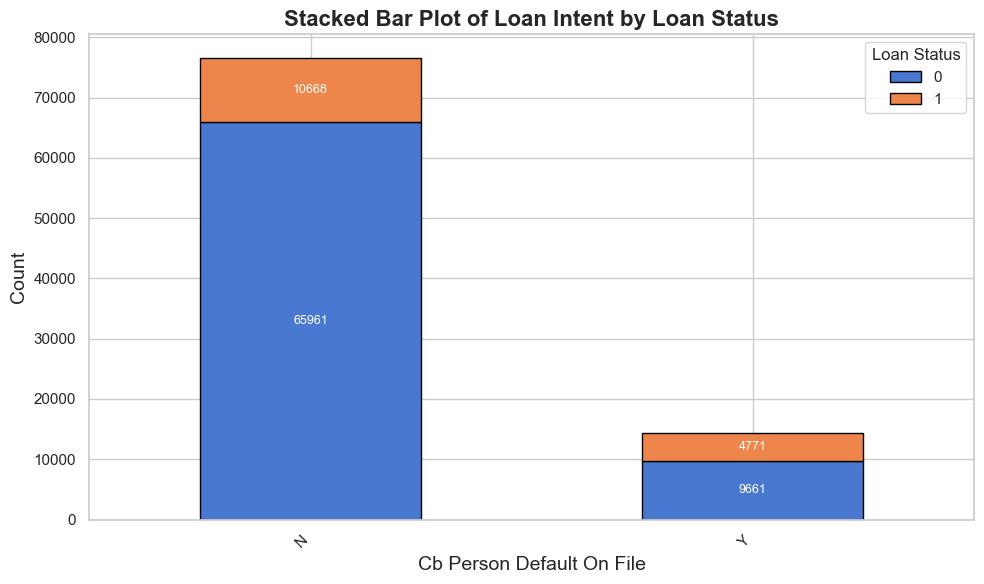

In [34]:

plot_stacked_bar(df_train, x_col='cb_person_default_on_file', hue_col='loan_status', title="Stacked Bar Plot of Loan Intent by Loan Status", palette=palette)


g = sns.FacetGrid(df_train, col="loan_grade", hue="loan_grade", col_wrap=3, height=4, palette="viridis", aspect=1.2)
g.map(sns.scatterplot, "cb_person_cred_hist_length", "person_income", alpha=0.6)
g.set_axis_labels("Credit History Length", "Person Income")
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Income vs. Credit History Length Across Loan Grades")
plt.show()


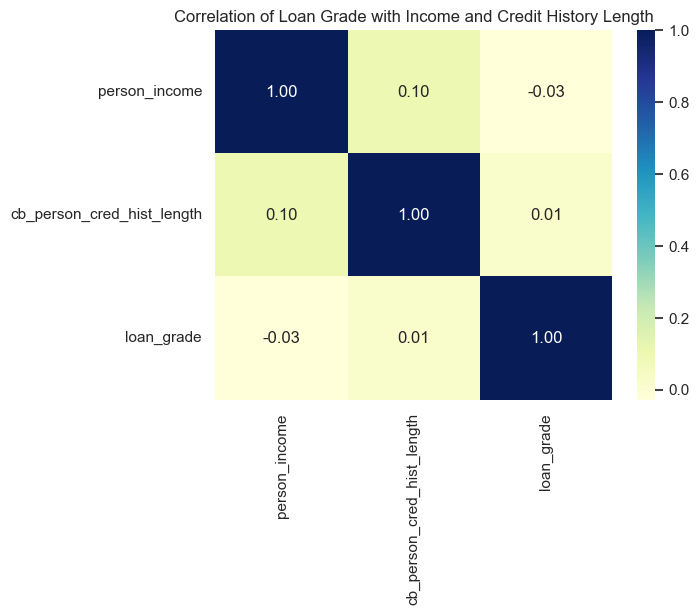

In [35]:
correlation_data = df_train[['person_income', 'cb_person_cred_hist_length', 'loan_grade']].copy()
correlation_data['loan_grade'] = correlation_data['loan_grade'].apply(lambda x: ord(x) - ord('A'))  # Convert grades to numeric
sns.heatmap(correlation_data.corr(), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation of Loan Grade with Income and Credit History Length")
plt.show()


In [36]:
# Set default Seaborn style
sns.set_style("whitegrid")

# Function to create count plots with different hues
def plot_countplot(data, x_col, hue_col=None, title="", palette='coolwarm', ax=None):
    sns.countplot(x=x_col, hue=hue_col, data=data, palette=palette, ax=ax)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel('Count')

# Function to create pie charts
def plot_piechart(data, column, title="", colors=None, explode_factor=0.05, ax=None):
    value_counts = data[column].value_counts()
    explode = [explode_factor] * len(value_counts)  # Slightly explode all slices
    ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
    ax.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
    ax.set_title(title)

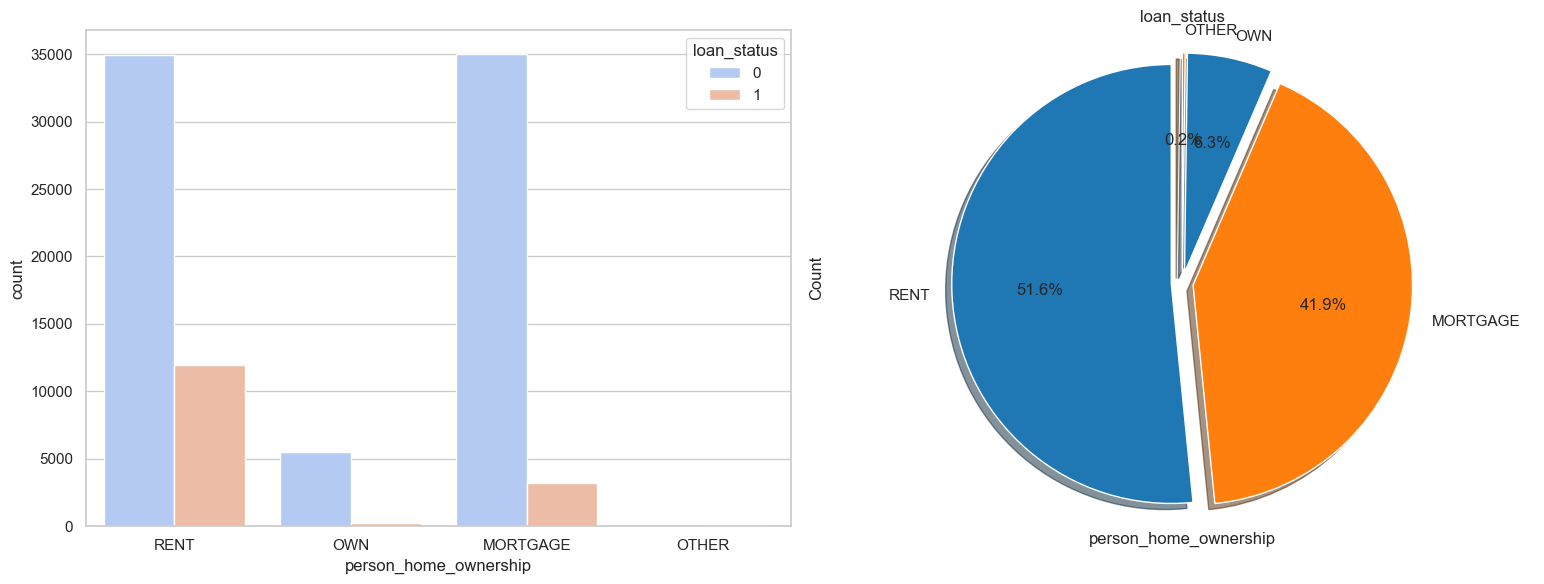

In [37]:
# Count plot and pie chart for Gender
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count plot
plot_countplot(df_train, x_col='person_home_ownership', hue_col='loan_status', title='Mental Health by Work Location', ax=axes[0])

plot_piechart(df_train, column='person_home_ownership', title='loan_status', colors=['#1f77b4', '#ff7f0e'], ax=axes[1])
plt.tight_layout()
plt.show()

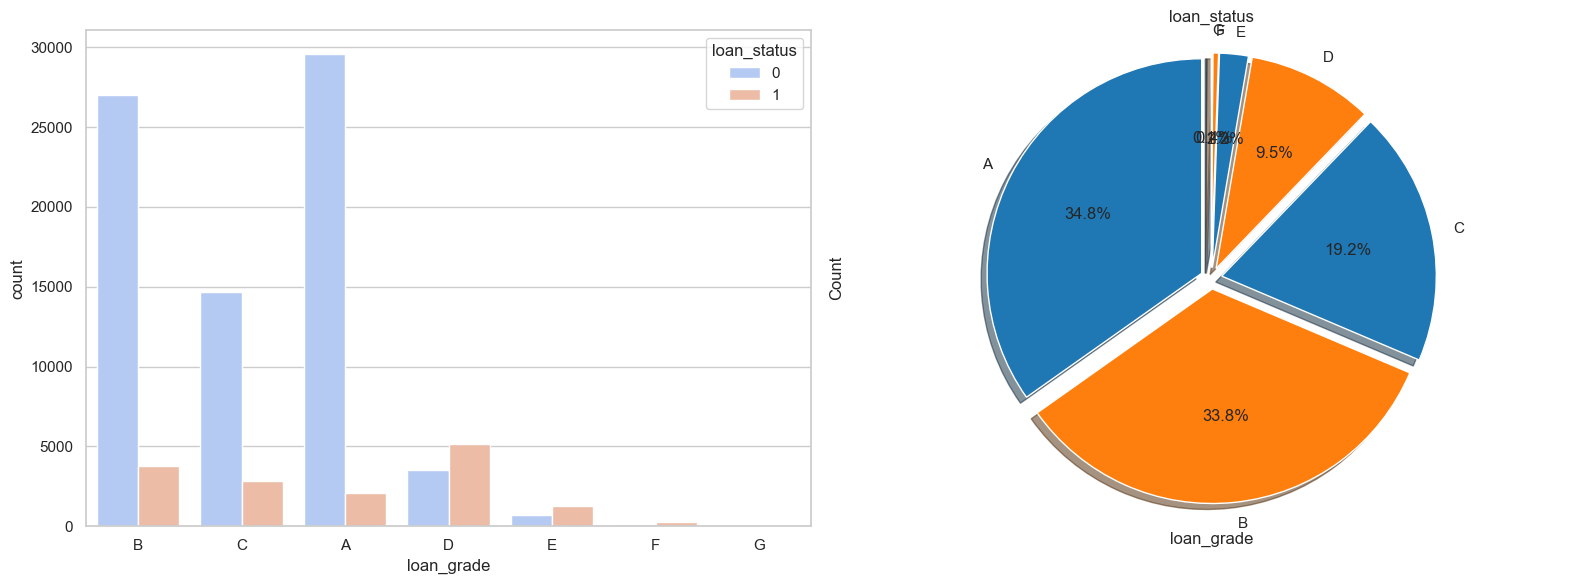

In [38]:
# Count plot and pie chart for Gender
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count plot
plot_countplot(df_train, x_col='loan_grade', hue_col='loan_status', title='Mental Health by Work Location', ax=axes[0])

plot_piechart(df_train, column='loan_grade', title='loan_status', colors=['#1f77b4', '#ff7f0e'], ax=axes[1])
plt.tight_layout()
plt.show()

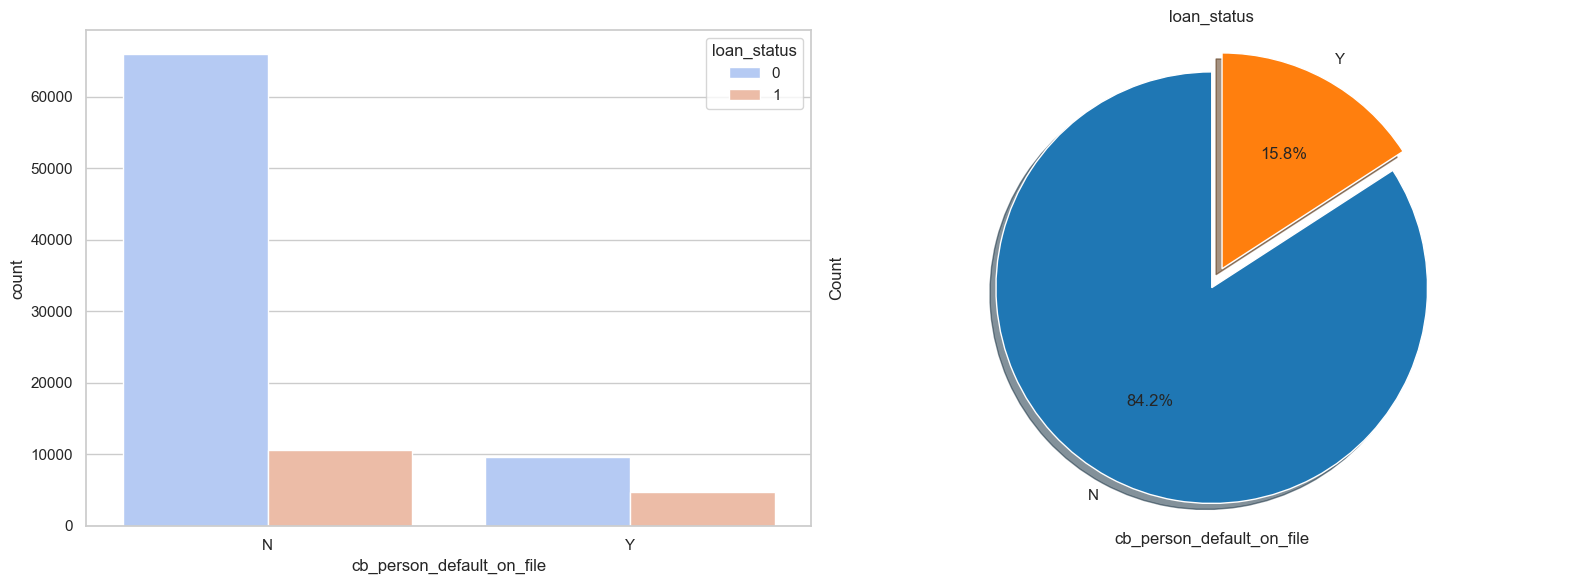

In [39]:
# Count plot and pie chart for Gender
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count plot
plot_countplot(df_train, x_col='cb_person_default_on_file', hue_col='loan_status', title='Mental Health by Work Location', ax=axes[0])

plot_piechart(df_train, column='cb_person_default_on_file', title='loan_status', colors=['#1f77b4', '#ff7f0e'], ax=axes[1])
plt.tight_layout()
plt.show()

In [40]:
def stacked_bar_chart(df, feature1, feature2): #figsize=(10, 6)
    """
    Creates a stacked bar chart to show the distribution of two categorical features.

    Parameters:
    - df: DataFrame containing the data.
    - feature1: The feature to be shown on the x-axis (categorical).
    - feature2: The feature to be stacked within each category of feature1.
    - figsize: Size of the plot.
    """
    # Create a cross-tabulation of the two features
    crosstab = pd.crosstab(df[feature1], df[feature2])
    
    # Plot the stacked bar chart
    crosstab.plot(kind="bar", stacked=True, figsize=(12,6), cmap='coolwarm')
    
    # Customize the plot
    plt.title(f"Stacked Bar Chart of {feature1} and {feature2}")
    plt.xlabel(feature1)
    plt.ylabel("proportion")
    plt.legend(title=feature2)
    plt.xticks(rotation=45)
    plt.show()

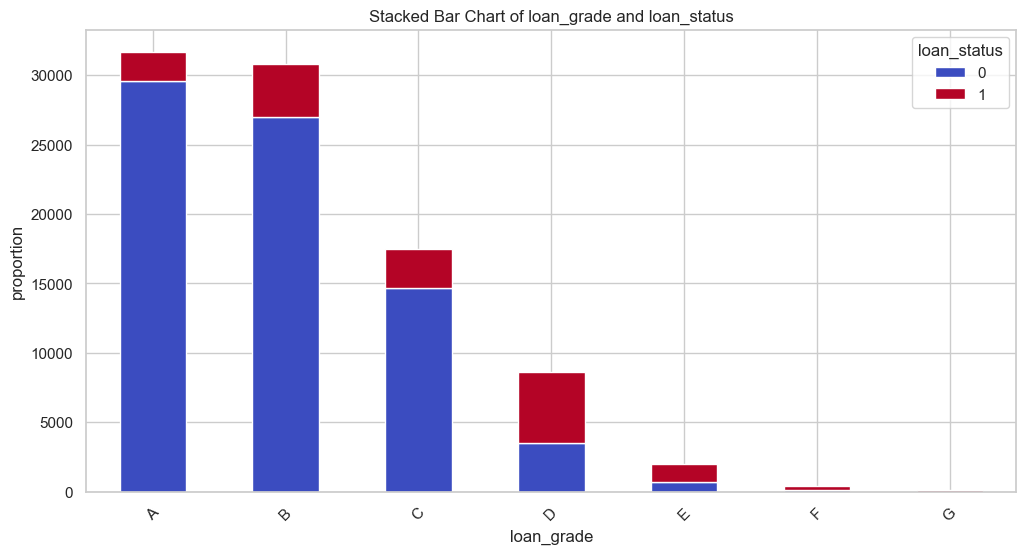

In [41]:
stacked_bar_chart(df_train, 'loan_grade', 'loan_status')

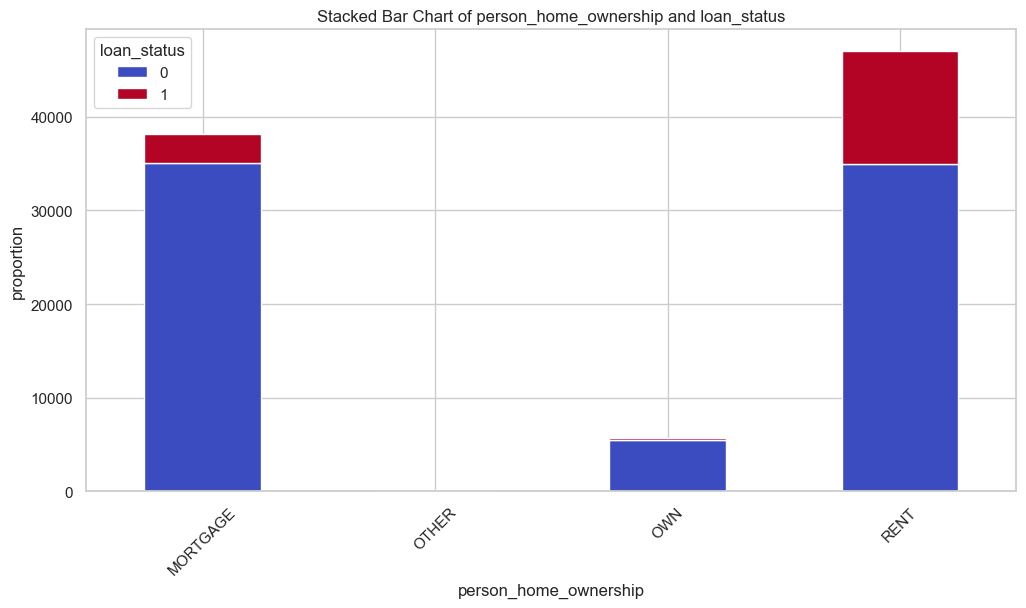

In [42]:
# Example usage:
stacked_bar_chart(df_train, 'person_home_ownership', 'loan_status')

### 2.5 Categorical and Ordinal Features

Let's examine the categorical and ordinal features more closely. Boxplots and violin plots are the most suited type of graphs for plotting a categorical variable

First we need to convert these columns to the category type:

In [43]:
categorical_features = ['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']
df_train[categorical_features] = df_train[categorical_features].astype('category')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91061 entries, 0 to 91060
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  91061 non-null  int64   
 1   person_income               91061 non-null  int64   
 2   person_home_ownership       91061 non-null  category
 3   person_emp_length           90174 non-null  float64 
 4   loan_intent                 91061 non-null  category
 5   loan_grade                  91061 non-null  category
 6   loan_amnt                   91061 non-null  int64   
 7   loan_int_rate               87966 non-null  float64 
 8   loan_percent_income         91061 non-null  float64 
 9   cb_person_default_on_file   91061 non-null  category
 10  cb_person_cred_hist_length  91061 non-null  int64   
 11  loan_status                 91061 non-null  int64   
dtypes: category(4), float64(3), int64(5)
memory usage: 5.9 MB


### 3. Conclusions of the EDA:

At the end of our EDA we have reached a few conclusions:

### Data Insights Summary:
1. **Loan Intent**: The most common loan purposes are **education**, **medical**, and **venture**, while **home improvement** is the least common.
2. **Loan Grades**: **Grades A and B** represent the majority of borrowers, but **Grade D** has the highest rate of default, indicating a riskier profile.
3. **Home Ownership**: 51.6% of borrowers **rent** their homes, 41.9% have a **mortgage**.
4. **Age and Credit History Distribution**: 
   - Ages range from **20 to 123** years, with a long-tailed distribution likely due to outliers.
   - **Credit history** spans from **2 to 30 years**, with longer histories potentially indicating financial stability.
5. **Loan Amount and Employment Length**:
   - Loan amounts range from **$500 to $35,000**.
   - Employment length has values up to **123 years**, suggesting outliers or data entry errors.
6. **Predictive Variables**: **Income** has a strong correlation with loan status, indicating it as a primary predictor. Variables like **age, employment length, interest rate, loan percent income**, and **credit history length** are also good predictors, despite not having a clear linear relationship with the target.
7. **Loan Default Correlation**:
   - Higher income is associated with loan defaults, though without a straightforward relationship with age.
   - **Grade A, B, and C** borrowers tend to have higher incomes and longer credit histories compared to lower grades.
8. **Credit File Defaults**: Borrowers with previous defaults in their credit files are more likely to default again.

### Key EDA Findings:
1. **Variable Types**: Identification of **quantitative**, **ordinal**, and **categorical** variables for better feature engineering.
2. **Missing Values**: Found in **person_emp_length** and **loan_int_rate**, requiring imputation.
3. **Duplicate Rows**: Present, which should be removed to avoid model bias.
4. **Outliers**: Detected in **person_income, person_age,** and **person_emp_length**; these need treatment to improve model performance.
5. **Data Skewness**: Present in **income, age, employment length**, and **income**, requiring transformation for normality.
6. **Scaling**: Necessary for numerical features due to differing scales, which some machine learning algorithms require.
7. **Encoding**: Required for categorical features like **person_home_ownership, loan_intent**, and **loan_grade** to use in machine learning.

## 4. Data Prepration 

## 4.1 Dealing with missing values

In [44]:
df_train.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

In [ ]:
# Check skewness
skewness = df_train['person_emp_length'].skew()
print(f"Skewness: {skewness}")

# Impute missing values
if skewness > 0:  # Positive skew
    df_train['person_emp_length'].fillna(df_train['person_emp_length'].median(), inplace=True)
else:  # Normal or negative skew
    df_train['person_emp_length'].fillna(df_train['person_emp_length'].mean(), inplace=True)

Skewness: 2.2728165207352418


In [46]:
# Check skewness
skewness = df_train['loan_int_rate'].skew()
print(f"Skewness: {skewness}")

# Impute missing values
if skewness > 0:  # Positive skew
    df_train['loan_int_rate'].fillna(df_train['loan_int_rate'].median(), inplace=True)
else:  # Normal or negative skew
    df_train['loan_int_rate'].fillna(df_train['loan_int_rate'].mean(), inplace=True)

Skewness: 0.21203194005666828


In [47]:
df_train.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

### 4.2 Feature Engineering
#### Feature Engineering plan 
1. `income_percentile:` Shows the relative standing of an individual's income compared to others in the dataset.
2. `income_to_credit_history:` Highlights how the income compares to the length of the credit history.
3. `estimated_annual_income:` Adjusted for hypothetical growth in income based on employment length (assuming a 3% annual growth rate).
4. `median_income_emp_group:` Provides the median income for groups with similar employment lengths.
5. `emp_length_category:` Categorizes employment length into intuitive groups.

In [ ]:
def refine_feature_engineering(df):
    # 1. Income Percentile (Relative Income)
    df['income_percentile'] = df['person_income'].rank(pct=True)

    # 2. Income-to-Credit-History Ratio
    df['income_to_credit_history'] = df['person_income'] / df['cb_person_cred_hist_length']

    # 3. Estimated Annual Income (assuming a 3% annual growth rate)
    df['estimated_annual_income'] = df['person_income'] / (1 + 0.03 * df['person_emp_length'].fillna(0))

    # 4. Median Income by Employment Length
    median_income_by_emp_length = df.groupby('person_emp_length')['person_income'].median()
    df['median_income_emp_group'] = df['person_emp_length'].map(median_income_by_emp_length)


    return df


In [49]:
df_engineered = refine_feature_engineering(df_train)

We now have 16 features in our dataset, but as we will see when preparing our data for feeding it into models we will get a few extra "dummy" features.

### 4.2.1 Check there are no missing values in the engineered dataset

In [51]:
## Look for rows with incomplete values
incomplete_rows = df_engineered[df_engineered.isna().any(axis=1)]
incomplete_rows

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,income_percentile,income_to_credit_history,estimated_annual_income,median_income_emp_group


### 4.3 Handling Categorical Attributes

In [52]:
from sklearn.preprocessing import OrdinalEncoder

# Specify the columns to encode
label_cols = ['person_home_ownership', 'loan_grade', 'cb_person_default_on_file']

# Instantiate the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Apply the encoder to the specified columns
df_engineered[label_cols] = ordinal_encoder.fit_transform(df_engineered[label_cols])

# View the transformed data
print(df_engineered.head())

   person_age  person_income  person_home_ownership  person_emp_length  \
0          37          35000                  3.000              0.000   
1          22          56000                  2.000              6.000   
2          29          28800                  2.000              8.000   
3          30          70000                  3.000             14.000   
4          22          60000                  3.000              2.000   

  loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION       1.000       6000         11.490                0.170   
1     MEDICAL       2.000       4000         13.350                0.070   
2    PERSONAL       0.000       6000          8.900                0.210   
3     VENTURE       1.000      12000         11.110                0.170   
4     MEDICAL       0.000       6000          6.920                0.100   

   cb_person_default_on_file  cb_person_cred_hist_length  loan_status  \
0                      0.

In [53]:
# View the mapping of categories
for col, categories in zip(label_cols, ordinal_encoder.categories_):
    print(f"Mapping for {col}: {categories}")

Mapping for person_home_ownership: ['MORTGAGE' 'OTHER' 'OWN' 'RENT']
Mapping for loan_grade: ['A' 'B' 'C' 'D' 'E' 'F' 'G']
Mapping for cb_person_default_on_file: ['N' 'Y']


### 4.3.1 One Hot Encoding on "loan_intent" column

In [54]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_data_cat = df_engineered[["loan_intent"]]
train_data_cat_1hot = cat_encoder.fit_transform(train_data_cat)
train_data_cat_1hot

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [55]:
cat_encoder.categories_

[array(['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL',
        'PERSONAL', 'VENTURE'], dtype=object)]

In [56]:
# Convert the encoded array into a DataFrame with meaningful column names
encoded_feature_names = cat_encoder.get_feature_names_out(["loan_intent"])
train_data_cat_encoded_df = pd.DataFrame(train_data_cat_1hot, columns=encoded_feature_names, index=df_engineered.index)

In [57]:
# Concatenate the new DataFrame with the original dataset
df_final = pd.concat([df_engineered, train_data_cat_encoded_df], axis=1).drop(columns=["loan_intent"])

In [58]:
df_final.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,...,income_percentile,income_to_credit_history,estimated_annual_income,median_income_emp_group,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,37,35000,3.000,0.000,1.000,6000,11.490,0.170,0.000,14,...,0.160,2500.000,35000.000,50000.000,0.000,1.000,0.000,0.000,0.000,0.000
1,22,56000,2.000,6.000,2.000,4000,13.350,0.070,0.000,2,...,0.493,28000.000,47457.627,57269.500,0.000,0.000,0.000,1.000,0.000,0.000
2,29,28800,2.000,8.000,0.000,6000,8.900,0.210,0.000,10,...,0.069,2880.000,23225.806,63996.000,0.000,0.000,0.000,0.000,1.000,0.000
3,30,70000,3.000,14.000,1.000,12000,11.110,0.170,0.000,5,...,0.674,14000.000,49295.775,73500.000,0.000,0.000,0.000,0.000,0.000,1.000
4,22,60000,3.000,2.000,0.000,6000,6.920,0.100,0.000,3,...,0.551,20000.000,56603.774,50000.000,0.000,0.000,0.000,1.000,0.000,0.000


### 4.4 feature Scaling

In [59]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91061 entries, 0 to 91060
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   person_age                     91061 non-null  int64  
 1   person_income                  91061 non-null  int64  
 2   person_home_ownership          91061 non-null  float64
 3   person_emp_length              91061 non-null  float64
 4   loan_grade                     91061 non-null  float64
 5   loan_amnt                      91061 non-null  int64  
 6   loan_int_rate                  91061 non-null  float64
 7   loan_percent_income            91061 non-null  float64
 8   cb_person_default_on_file      91061 non-null  float64
 9   cb_person_cred_hist_length     91061 non-null  int64  
 10  loan_status                    91061 non-null  int64  
 11  income_percentile              91061 non-null  float64
 12  income_to_credit_history       91061 non-null 

In [60]:
numerical_features = [
    'person_age', 'person_income', 'person_emp_length', 
    'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
    'cb_person_cred_hist_length', 'cb_person_cred_hist_length', 'income_percentile',
    'income_to_credit_history',	'estimated_annual_income', 'median_income_emp_group'
]

In [61]:
from sklearn.preprocessing import StandardScaler
# Standardization for numerical data
# Initilize the scaler 
scaler = StandardScaler()
# Apply Scaling to Numerical Features
df_final[numerical_features] = scaler.fit_transform(df_final[numerical_features])

In [62]:
df_final.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,...,income_percentile,income_to_credit_history,estimated_annual_income,median_income_emp_group,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,1.525,-0.621,3.000,-1.179,1.000,-0.573,0.227,0.070,0.000,2.027,...,-1.178,-1.019,-0.540,-0.977,0.000,1.000,0.000,0.000,0.000,0.000
1,-0.914,-0.183,2.000,0.318,2.000,-0.915,0.836,-0.956,0.000,-0.944,...,-0.025,0.933,-0.230,0.141,0.000,0.000,0.000,1.000,0.000,0.000
2,0.224,-0.751,2.000,0.817,0.000,-0.573,-0.621,0.481,0.000,1.036,...,-1.493,-0.990,-0.833,1.176,0.000,0.000,0.000,0.000,1.000,0.000
3,0.387,0.109,3.000,2.315,1.000,0.453,0.103,0.070,0.000,-0.201,...,0.604,-0.138,-0.184,2.638,0.000,0.000,0.000,0.000,0.000,1.000
4,-0.914,-0.100,3.000,-0.680,0.000,-0.573,-1.268,-0.648,0.000,-0.696,...,0.176,0.321,-0.003,-0.977,0.000,0.000,0.000,1.000,0.000,0.000


In [63]:
"""
y = df_train['loan_status'] 
df_train = df_train.drop(['loan_status'],axis=1)
X = df_train

"""

"\ny = df_train['loan_status'] \ndf_train = df_train.drop(['loan_status'],axis=1)\nX = df_train\n\n"

In [95]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

def data_prepared(df, cat_encoder, ordinal_encoder, scaler):
    # Handle Missing Values Based on Skewness
    for col in ['person_emp_length', 'loan_int_rate']:
        skewness = df[col].skew()  # Check skewness
        if skewness > 0:  # Positively skewed
            df[col].fillna(df[col].median(), inplace=True)
        else:  # Normal or negative skew
            df[col].fillna(df[col].mean(), inplace=True)

    # 1. Income Percentile (Relative Income)
    df['income_percentile'] = df['person_income'].rank(pct=True)

    # 2. Income-to-Credit-History Ratio
    df['income_to_credit_history'] = df['person_income'] / df['cb_person_cred_hist_length']

    # 3. Estimated Annual Income (assuming a 3% annual growth rate)
    df['estimated_annual_income'] = df['person_income'] / (1 + 0.03 * df['person_emp_length'].fillna(0))

    # 4. Median Income by Employment Length
    median_income_by_emp_length = df.groupby('person_emp_length')['person_income'].median()
    df['median_income_emp_group'] = df['person_emp_length'].map(median_income_by_emp_length)

    # 5. One-Hot Encoding for 'loan_intent'
    train_data_cat_1hot = cat_encoder.transform(df[["loan_intent"]])
    onehot_columns = cat_encoder.get_feature_names_out(["loan_intent"])
    train_data_cat_1hot_df = pd.DataFrame(train_data_cat_1hot, columns=onehot_columns, index=df.index)

    # Concatenate One-Hot Encoded Data
    df = pd.concat([df, train_data_cat_1hot_df], axis=1).drop(columns=['loan_intent'])

    # 6. Ordinal Encoding for 'person_home_ownership', 'loan_grade', 'cb_person_default_on_file'
    ordinal_features = ['person_home_ownership', 'loan_grade', 'cb_person_default_on_file']
    df[ordinal_features] = ordinal_encoder.transform(df[ordinal_features])

    # 7. Standardization for numerical data
    numerical_features = [
    'person_age', 'person_income', 'person_emp_length', 
    'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
    'cb_person_cred_hist_length', 'cb_person_cred_hist_length', 'income_percentile',
    'income_to_credit_history',	'estimated_annual_income', 'median_income_emp_group'
]
    df[numerical_features] = scaler.transform(df[numerical_features])

    return df


In [106]:
# Define categorical and ordinal features
categorical_features = ["loan_intent"]
ordinal_features = ["person_home_ownership", "loan_grade", "cb_person_default_on_file"]
numerical_features = [
    'person_age', 'person_income', 'person_emp_length', 
    'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
    'cb_person_cred_hist_length', 'cb_person_cred_hist_length', 'income_percentile',
    'income_to_credit_history',	'estimated_annual_income', 'median_income_emp_group'
]

# Separate target variable
y_train = copy_train["loan_status"]
X_train = copy_train.drop(columns=["loan_status"])

# Instantiate encoders and scaler
cat_encoder = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder()
scaler = StandardScaler()

# Fit encoders & scaler on training data
cat_encoder.fit(X_train[categorical_features])
ordinal_encoder.fit(X_train[ordinal_features])
scaler.fit(X_train[numerical_features])


c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


StandardScaler()

In [124]:
test_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,income_percentile,income_to_credit_history,estimated_annual_income,median_income_emp_group
0,58645,23,69000,RENT,3.000,HOMEIMPROVEMENT,F,25000,15.760,0.360,N,2,0.657,34500.000,63302.752,55782.000
1,58646,26,96000,MORTGAGE,6.000,PERSONAL,C,10000,12.680,0.100,Y,4,0.875,24000.000,81355.932,58947.000
2,58647,26,30000,RENT,5.000,VENTURE,E,4000,17.190,0.130,Y,2,0.075,15000.000,26086.957,55000.000
3,58648,33,50000,RENT,4.000,DEBTCONSOLIDATION,A,7000,8.900,0.140,N,7,0.382,7142.857,44642.857,57923.000
4,58649,26,102000,MORTGAGE,8.000,HOMEIMPROVEMENT,D,15000,16.320,0.150,Y,4,0.904,25500.000,82258.065,62500.000


In [126]:
test_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.000,HOMEIMPROVEMENT,F,25000,15.760,0.360,N,2
1,58646,26,96000,MORTGAGE,6.000,PERSONAL,C,10000,12.680,0.100,Y,4
2,58647,26,30000,RENT,5.000,VENTURE,E,4000,17.190,0.130,Y,2
3,58648,33,50000,RENT,4.000,DEBTCONSOLIDATION,A,7000,8.900,0.140,N,7
4,58649,26,102000,MORTGAGE,8.000,HOMEIMPROVEMENT,D,15000,16.320,0.150,Y,4


In [105]:
copy_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,income_percentile,income_to_credit_history,estimated_annual_income,median_income_emp_group
0,37,35000,RENT,0.000,EDUCATION,B,6000,11.490,0.170,N,14,0,0.160,2500.000,35000.000,50000.000
1,22,56000,OWN,6.000,MEDICAL,C,4000,13.350,0.070,N,2,0,0.493,28000.000,47457.627,57187.500
2,29,28800,OWN,8.000,PERSONAL,A,6000,8.900,0.210,N,10,0,0.069,2880.000,23225.806,63996.000
3,30,70000,RENT,14.000,VENTURE,B,12000,11.110,0.170,N,5,0,0.674,14000.000,49295.775,74000.000
4,22,60000,RENT,2.000,MEDICAL,A,6000,6.920,0.100,N,3,0,0.551,20000.000,56603.774,50000.000


In [107]:
# Transform training data
df_train_prepared = data_prepared(X_train, cat_encoder, ordinal_encoder, scaler)

In [141]:
y_test = sample_submission["loan_status"]  # Extract actual labels
#X_test = test_data  # Keep only the test features

In [140]:
# Transform test data using the same fitted encoders & scaler
df_test_prepared = data_prepared(test_data, cat_encoder, ordinal_encoder, scaler)

### 5. Save all the prepared data - train and test

Let's save the datasets as CSV files in a newly created `prepared` subdirectory of `datasets`:

In [88]:
os.makedirs("../datasets/prepared/", exist_ok=True)
df_train_prepared.to_csv("../datasets/prepared/kd-housing-train.csv", index=False)
df_test_prepared.to_csv("../datasets/prepared/kd-housing-test.csv", index=False)

In [ ]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64

## 6.  Features Importance 

In [100]:
df_train_prepared.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_grade                       0
loan_amnt                        0
loan_int_rate                    0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
income_percentile                0
income_to_credit_history         0
estimated_annual_income          0
median_income_emp_group          0
loan_intent_DEBTCONSOLIDATION    0
loan_intent_EDUCATION            0
loan_intent_HOMEIMPROVEMENT      0
loan_intent_MEDICAL              0
loan_intent_PERSONAL             0
loan_intent_VENTURE              0
dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_train_prepared, y_train)

# Get feature importance
feature_importance = pd.Series(rf.feature_importances_, index=df_train_prepared.columns)

In [111]:
# Convert into a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': df_train_prepared.columns,
    'Importance': feature_importance
})

# Sort features by importance (highest to lowest)
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

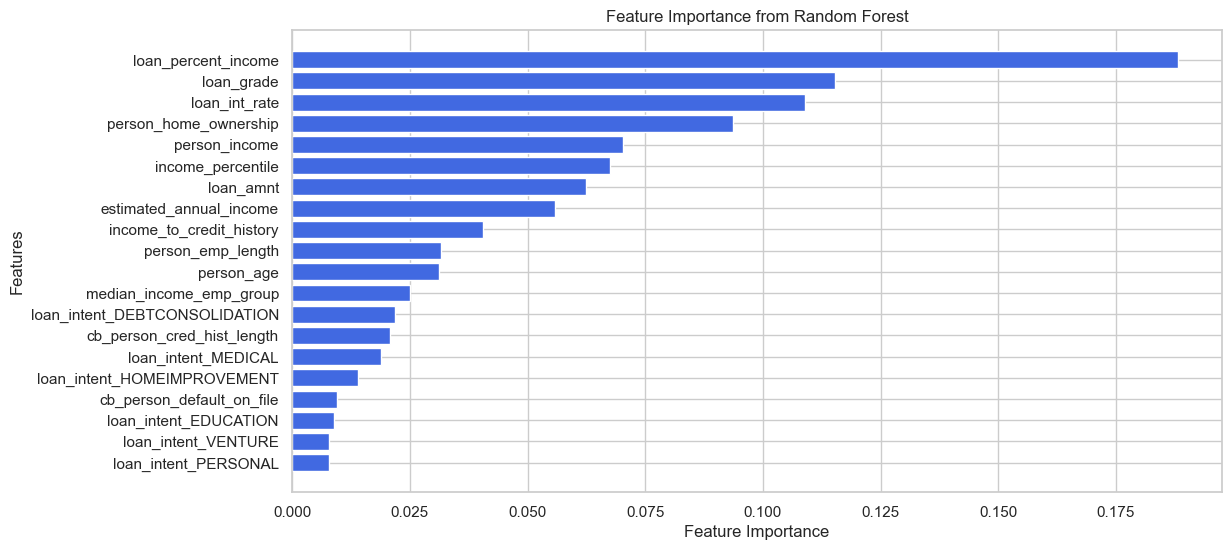

In [112]:
plt.figure(figsize=(12,6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="royalblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()  # To display most important features at the top
plt.show()

In [117]:
top_n = 11  # Choose how many top features you want
top_features = feature_importance_df.iloc[:top_n]["Feature"].tolist()

In [118]:
threshold = 0.01  # Keep features with importance > 1%
selected_features = feature_importance_df[feature_importance_df["Importance"] > threshold]["Feature"].tolist()

In [121]:
X_train_selected = df_train_prepared[top_features]  # Use only selected features for training
X_test_selected = df_test_prepared[top_features]

In [120]:
X_train_selected.head()

,loan_percent_income,loan_grade,loan_int_rate,person_home_ownership,person_income,income_percentile,loan_amnt,estimated_annual_income,income_to_credit_history,person_emp_length,person_age
0,0.070,1.000,0.227,3.000,-0.621,-1.177,-0.573,-0.540,-1.019,-1.179,1.526
1,-0.956,2.000,0.836,2.000,-0.183,-0.025,-0.915,-0.230,0.933,0.318,-0.914
2,0.481,0.000,-0.620,2.000,-0.750,-1.492,-0.573,-0.832,-0.990,0.818,0.225
3,0.070,1.000,0.103,3.000,0.109,0.604,0.453,-0.184,-0.139,2.315,0.388
4,-0.648,0.000,-1.268,3.000,-0.100,0.176,-0.573,-0.002,0.321,-0.680,-0.914


### 6. LGBMClassifier with StratifiedKFold


In [ ]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

y = y_train

# Define LightGBM parameters
lgb_params = {                    
    'objective': 'binary', # This is a binary classification task.
    'n_estimators': 3000, # The model will train for up to 3000 boosting rounds.
    'metric': 'binary_logloss', # The evaluation metric is log loss, suitable for binary classification.
    'boosting_type': 'gbdt', # Uses Gradient Boosting Decision Trees (GBDT).
    'random_state': 42, # Ensures reproducibility of results.
    'learning_rate': 0.0323, # Controls step size during training.
    'num_leaves': 24, # Controls the complexity of the trees.
    'max_depth': 15, # Limits tree depth to prevent overfitting.
    'min_data_in_leaf': 25,  # Ensures each leaf has at least 25 data points.
    'feature_fraction': 0.6236, # Uses 62% of features per tree (feature sampling).
    'bagging_fraction': 0.9597, #Uses 96% of data per tree (row sampling).
    'bagging_freq': 3,  # Performs bagging every 3 boosting iterations.
    'verbose': -1 # Suppresses LightGBM logs.
}

# Setting Up Stratified K-Fold Cross-Validation
n_splits = 5 # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) # StratifiedKFold ensures that each fold maintains the 
                                                                    # same proportion of the target class, shuffle=True helps in generalization.


# Initialize arrays to store predictions
lgbm_predictions = np.zeros(len(X_train_selected))
lgbm_true_labels = np.zeros(len(X_train_selected))
lgbm_test_predictions = np.zeros(len(X_test_selected))

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_selected, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    # Split data into train and validation sets
    X_train, X_val = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]    
    
    # Initialize and train the model
    lgbm_model = LGBMClassifier(**lgb_params)
    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='auc',
                   early_stopping_rounds=10,
                   verbose=False)    

    # Predict on validation and test data
    lgbm_fold_preds = lgbm_model.predict_proba(X_val)[:, 1]  
    lgbm_fold_test_preds = lgbm_model.predict_proba(X_test_selected)[:, 1]   
    
    # Store predictions
    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val    
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits

# Compute overall AUC score
overall_metric_lgbm = roc_auc_score(lgbm_true_labels, lgbm_predictions)
print("Overall AUC (LGBMClassifier with StratifiedKFold):", overall_metric_lgbm)


Training fold 1/5...


c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6236
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9597
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training fold 2/5...
[LightGBM] [Warning] feature_fraction is set=0.6236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6236
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9597
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training fold 3/5...
[LightGBM] [Warning] feature_fraction is set=0.6236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6236
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9597
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training fold 4/5...
[LightGBM] [Warning] feature_fraction is set=0.6236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6236
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9597
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training fold 5/5...
[LightGBM] [Warning] feature_fraction is set=0.6236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6236
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.9597, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9597
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\nuhaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Overall AUC (LGBMClassifier with StratifiedKFold): 0.9471420076367707


### 6.1 ROC Curve: Higher AUC means better model performance.

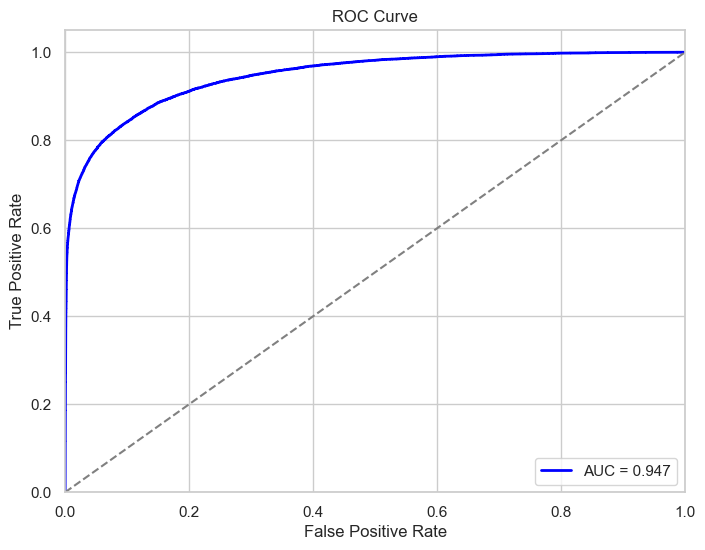

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# Ensure plots are high resolution
plt.rcParams['figure.dpi'] = 100

# ROC curve plot
fpr, tpr, _ = roc_curve(lgbm_true_labels, lgbm_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.2 Precision-Recall Curve: Helps understand trade-offs in precision vs. recall.

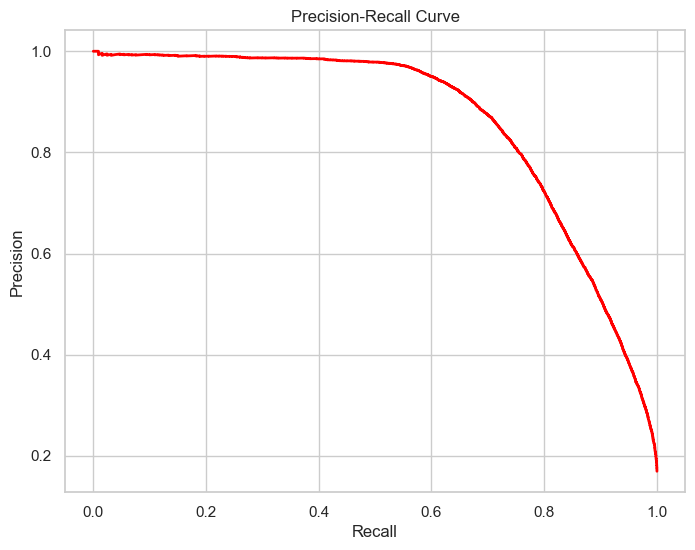

In [171]:
# plot precision-recall curve 
precision, recall, _ = precision_recall_curve(lgbm_true_labels, lgbm_predictions)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### 6.3 Feature Importance: Identifies which features influence predictions most.

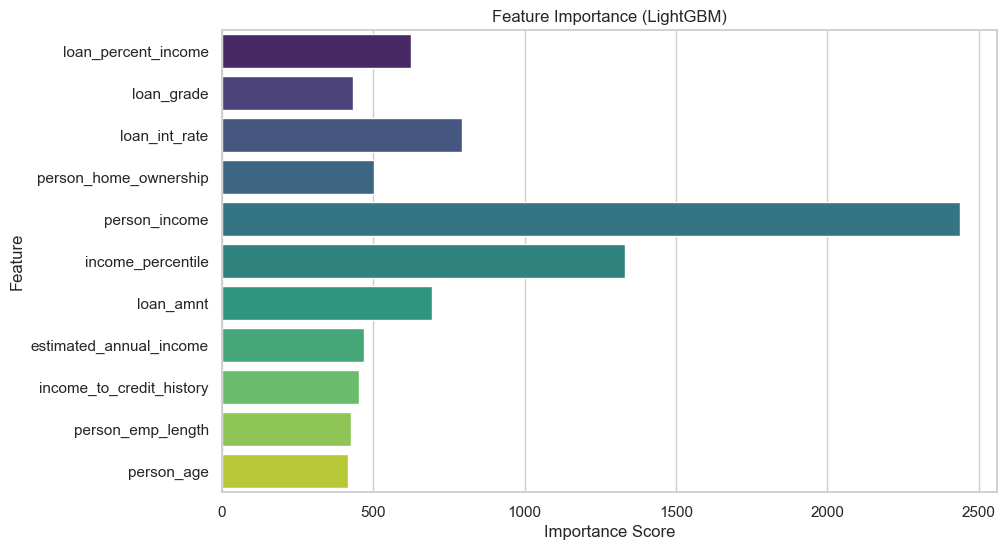

In [172]:
# Feature Importances Plot
importances = lgbm_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette='viridis')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (LightGBM)')
plt.show()


### 6.4 Confusion Matrix: Shows how well the model distinguishes between classes.

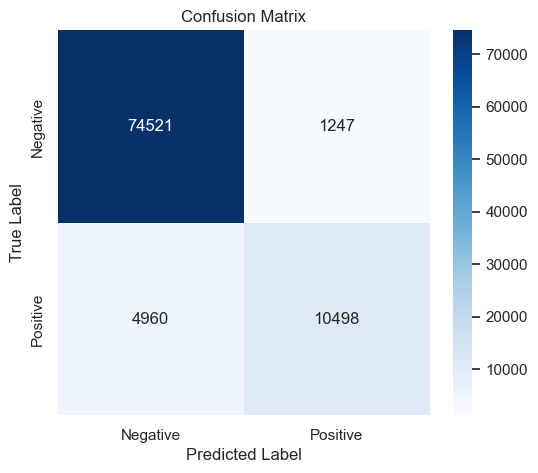

In [173]:
# Confusion Matrix 
cm = confusion_matrix(lgbm_true_labels, (lgbm_predictions > 0.5).astype(int))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
